## Regulatory Compliance Analysis

This notebook analyzes Thessaloniki's short-term rental licensing compliance 
patterns to identify regulatory framework effectiveness and concentration risks.

### Regulatory Background
- **Regular Licenses:** Standard operating permits (required for most properties)
- **Exempt Status:** Policy exemptions for specific property categories
- **Duplicate Licenses:** Single license shared across multiple properties
- **NA/Missing:** Properties operating without clear licensing status

### Research Questions
1. How many listings are unlicensed or falsely claiming exemptions?
2. Is the licensing system achieving its policy objectives of equitable market access while preventing operator concentration?

### Key Finding Preview
> **High compliance, concentrated exemptions.** 97.3% of active listings hold valid licenses, but 2 hosts control 42% of all exemptions and 6 licenses are shared suspiciously across multiple hosts/locations. After filtering 115 non-compliant listings (2.7%), 4,124 regular licensed listings remain for analysis.

In [23]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data_path = Path.cwd().parent / "data" / "processed"
df = pd.read_parquet(data_path / "listings_cleaned.parquet")
pd.set_option('display.float_format', '{:,.2f}'.format)
df.shape

(4239, 54)

In [24]:
# Set global style and color palette
sns.set_theme(style="whitegrid")
sns.set_palette("Set2")  # or "husl", "muted", "pastel", "deep", "colorblind"

# For matplotlib defaults
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=sns.color_palette("Set2"))

In [25]:
# Create masks for different license categories
na_mask = df["license"].isna()
dupli_mask = df["license"].duplicated(keep=False) & df["license"].notna() & (df["license"] != "exempt")
exempt_mask = df["license"] == "exempt"

# Filter dataframes by license status
na_df = df[na_mask]
dupli_df = df[dupli_mask]
exempt_df = df[exempt_mask]

In [26]:
print("=" * 50)
print("LICENSE STATUS OVERVIEW")
print("=" * 50)
print(f"Licensed listings:   {(1 - na_mask.mean()):.2%}")
print(f"Duplicate licenses:  {dupli_mask.mean():.2%}")
print(f"Exempt licenses:     {exempt_mask.mean():.2%}")
print(f"Unlicensed (NA):     {na_mask.mean():.2%}")

LICENSE STATUS OVERVIEW
Licensed listings:   99.60%
Duplicate licenses:  6.13%
Exempt licenses:     0.57%
Unlicensed (NA):     0.40%


<hr>

## NA licenses

In [27]:
print(f"Unlicensed listings: {len(na_df):,}")

Unlicensed listings: 17


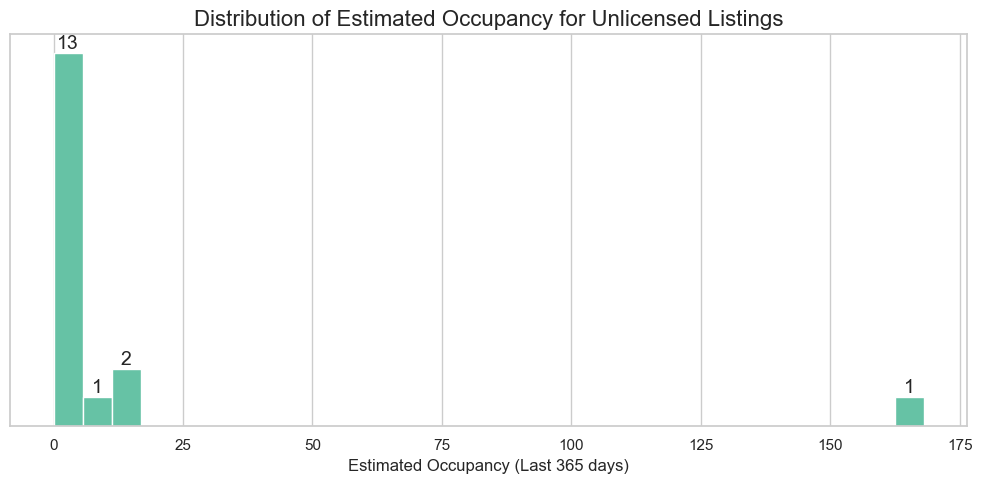

In [28]:
fig, ax = plt.subplots(figsize=(10, 5))
counts, bins, patches = ax.hist(na_df["estimated_occupancy_l365d"], bins=30)

# Add labels on top of bars
for count, patch in zip(counts, patches):
    if count > 0:
        ax.text(patch.get_x() + patch.get_width()/2, count, f'{int(count)}',
                ha='center', va='bottom', fontsize=14)

ax.set_xlabel('Estimated Occupancy (Last 365 days)')
ax.set_yticks([])
ax.set_title('Distribution of Estimated Occupancy for Unlicensed Listings', fontsize=16)
plt.tight_layout()
plt.show()

In [29]:
active_unlicensed = na_df.loc[na_df["estimated_occupancy_l365d"] != 0].shape[0]
recent_reviews = na_df.loc[na_df["last_review"] > "2023-01-01"].shape[0]

print(f"With non-zero occupancy: {active_unlicensed}")
print(f"With reviews after 2023: {recent_reviews}")

With non-zero occupancy: 4
With reviews after 2023: 4


In [30]:
na_df[["id", "last_review"]].sort_values(by="last_review", ascending=False).head(7)

,id,last_review
526,PROP_824E45,2025-06-23
743,PROP_00CC6D,2025-06-10
759,PROP_9ACF5F,2025-06-09
572,PROP_D0CC28,2025-06-04
956,PROP_C55989,2020-03-02
297,PROP_7C20E2,2020-03-01
107,PROP_E11B35,2020-02-28


In [31]:
active_listing_index = na_df["estimated_occupancy_l365d"].idxmax()
df.loc[active_listing_index, ["last_review", "review_scores_rating", 
                               "estimated_revenue_l365d", "listing_age_years"]]

last_review                2025-06-09
review_scores_rating             4.96
estimated_revenue_l365d     12,096.00
listing_age_years                5.95
Name: 759, dtype: object

#### Main Findings

* Apart from 4 listings that seem currently active, all the rest seem like dead listings.
* A particular listing is highly active in the market performing really well.

<hr>

## Exempt Licenses

In [32]:
print(f"Exempt listings: {len(exempt_df):,}")

Exempt listings: 24


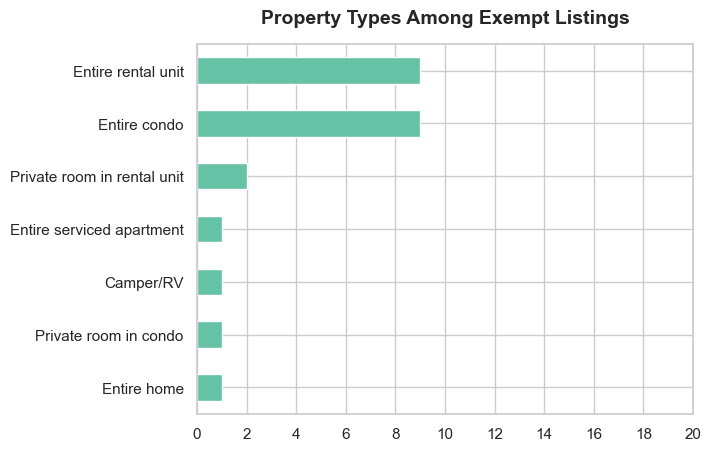

In [46]:
ax = exempt_df["property_type"].value_counts(ascending=True).tail(7).plot.barh()
ax.set_xticks(range(0, 21, 2))
ax.set_xlim(0, 20)
ax.set_ylabel('')
ax.set_title('Property Types Among Exempt Listings', fontsize=14, fontweight='bold', pad=15);

In [34]:
exempt_df.groupby(['host_id', "host_location"]).agg(
    listing_count=("host_id", "count"),
    total_revenue_l365d=("estimated_revenue_l365d", "sum"),
    min_availability_365d=("availability_365", "min"),
    last_review_date=("last_review_date", "max")
).sort_values("listing_count", ascending=False).reset_index()

,host_id,host_location,listing_count,total_revenue_l365d,min_availability_365d,last_review_date
0,HOST_195D33,"London, United Kingdom",5,"8,304.00",180,2025-06-08
1,HOST_5CBB76,"Belgrade, Serbia",5,822.00,351,2024-11-25
2,HOST_5A66C8,"Thessaloniki, Greece",2,0.00,267,2024-05-20
3,HOST_415740,"Thessaloniki, Greece",1,282.00,264,2025-06-07
4,HOST_68CAF6,"Novi Sad, Serbia",1,0.00,296,2022-06-13
5,HOST_A9304D,"Athens, Greece",1,984.00,355,2025-06-04
6,HOST_C42CEA,"Thessaloniki, Greece",1,"1,500.00",359,2025-06-04
7,HOST_CB8B8B,"Thessaloniki, Greece",1,666.00,144,2025-06-06
8,HOST_CD009F,"London, United Kingdom",1,528.00,271,2025-05-16
9,HOST_F2C652,"Thessaloniki, Greece",1,"2,160.00",54,2025-06-15


In [35]:
top_2_per = exempt_df["host_id"].value_counts(normalize=True).head(2).sum()
print(f"Top 2 hosts account for {top_2_per:.2%} of all exemptions.")

Top 2 hosts account for 41.67% of all exemptions.


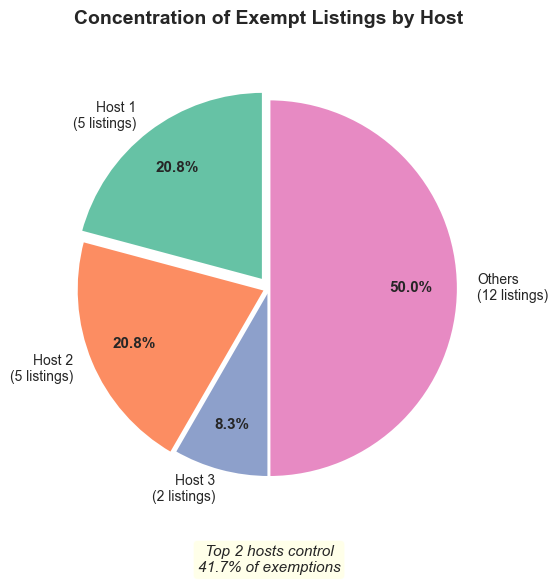

In [36]:
# Exempt listings concentration by host
counts = exempt_df["host_id"].value_counts()
top_n = counts.head(3)
others_count = counts.iloc[3:].sum()

# Create labels with counts
labels = [f'Host {i+1}\n({v} listings)' for i, v in enumerate(top_n.values)]
labels.append(f'Others\n({others_count} listings)')

values = list(top_n.values) + [others_count]

# Color palette - highlight top hosts
colors = sns.color_palette("Set2", n_colors=6)

fig, ax = plt.subplots(figsize=(10, 6))
wedges, texts, autotexts = ax.pie(
    values, 
    labels=labels,
    autopct='%1.1f%%',
    colors=colors,
    explode=[0.05, 0.02, 0, 0],  # Emphasize top 2
    startangle=90,
    pctdistance=0.75,
    wedgeprops={'linewidth': 2, 'edgecolor': 'white'}
)

# Style the percentage labels
for autotext in autotexts:
    autotext.set_fontsize(11)
    autotext.set_fontweight('bold')

# Style the labels
for text in texts:
    text.set_fontsize(10)

ax.set_title('Concentration of Exempt Listings by Host', fontsize=14, fontweight='bold', pad=20)

# Add annotation
ax.annotate(f'Top 2 hosts control\n{(top_n.head(2).sum() / counts.sum()):.1%} of exemptions',
            xy=(0.5, -0.1), xycoords='axes fraction',
            ha='center', fontsize=11, style='italic',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='lightyellow', alpha=0.7))

plt.tight_layout()
plt.show()

In [37]:
superhosts = exempt_df.loc[exempt_df["host_is_superhost"] == True].shape[0]
print(f"Superhosts among exempt: {superhosts}")

Superhosts among exempt: 4


#### Main Findings

* A few hosts with multiple exemptions, especially two hosts with almost 21% of all exemptions each (41.6% together)
* No particular geographical pattern that warrants exemptions
* Apart from one listing that is of type "Camper/RV", all the rest are of regular property type
* Minimum availability for most listings is quite high, indicating properties that are not main residences
* Many hosts are not located in Greece
* Many listings have recent reviews, indicating active rentals
* 4 of these hosts are superhosts

<hr>

## Duplicate Licenses

In [38]:
print(f"Listings with duplicate licenses: {len(dupli_df):,}")

Listings with duplicate licenses: 260


**Note:** The `location` column is derived by rounding latitude and longitude coordinates to 3 decimal places (approximately 111-meter precision) and concatenating them. While this provides a reasonable proxy for identifying distinct listing locations, results should be interpreted with caution due to potential rounding artifacts and data quality variations.

In [39]:
dupli_df = dupli_df.copy()
dupli_df["location"] = (round(dupli_df["latitude"], 3).astype(str) + 
    "_" + 
    round(dupli_df["longitude"], 3).astype(str))

dupli_groupped = dupli_df.groupby("license").agg(
    host_count=("host_id", "nunique"),
    location_count=("location", "nunique"),
    listings_count=("license", "count"),
    total_revenue=("estimated_revenue_l365d", "sum"),
    avg_reviews_ltm=("number_of_reviews_ltm", "mean"),
).sort_values(["host_count", "location_count"], ascending=False)

dupli_groupped.head(20)

,host_count,location_count,listings_count,total_revenue,avg_reviews_ltm
license,,,,,
LIC_7C3F33BD,3,6,12,"6,682.00",2.08
LIC_7BF7E0E7,2,4,4,"10,836.00",8.00
LIC_C57F46E7,2,3,3,612.00,12.33
LIC_0010A65B,2,2,2,"11,802.00",7.50
LIC_061E18A2,2,2,2,"8,700.00",17.50
LIC_30293A17,2,1,2,"4,698.00",9.00
LIC_83627B25,1,7,8,0.00,0.00
LIC_CE1F25AE,1,7,9,0.00,0.00
LIC_0A0769D5,1,5,5,"5,364.00",3.80


In [40]:
# Flag suspicious licenses: multiple hosts OR multiple locations
dupli_licenses_to_drop = dupli_groupped.loc[
    (dupli_groupped["location_count"] > 2) | (dupli_groupped["host_count"] > 1)
].index
dupli_indices_to_drop = dupli_df.loc[dupli_df["license"].isin(dupli_licenses_to_drop)].index

print(f"Suspicious licenses flagged: {len(dupli_licenses_to_drop)}")
print(f"Listings to exclude: {len(dupli_indices_to_drop):,}")

Suspicious licenses flagged: 17
Listings to exclude: 74


In [41]:
pct_flagged = len(dupli_indices_to_drop) / len(dupli_df)
print(f"Share of duplicate licenses flagged: {pct_flagged:.1%}")

Share of duplicate licenses flagged: 28.5%


In [42]:
dupli_df["host_id"].value_counts().head(5)

host_id
HOST_4497DA    43
HOST_044261    22
HOST_6D3C82    12
HOST_7C4743    10
HOST_BCCB87     9
Name: count, dtype: int64

In [43]:
# Analyze top host with duplicate licenses
interesting_host_id_2 = dupli_df["host_id"].value_counts().head(1).index[0]
host_listings = dupli_df.loc[dupli_df["host_id"] == interesting_host_id_2]

print(f"Top host's total listings with duplicate licenses: {len(host_listings)}")
print(f"Top host's unique licenses: {host_listings['license'].nunique()}")
print(f"Top host's share of duplicates: {len(host_listings) / len(dupli_df):.1%}")

Top host's total listings with duplicate licenses: 43
Top host's unique licenses: 6
Top host's share of duplicates: 16.5%


#### Main Findings

* 6 licenses are under more than one host, 5 of them at more than one location
* 74 such listings (28.5% of duplicate licenses) will be dropped from further analysis
* A particular host holds 29 different listings under one license, and 43 listings (16.5% of total duplicate listings) under 6 licenses overall

<hr>

### **Summary and Recommendations**

* Apart from 4 unlicensed listings that seem currently active, all the rest seem like deactivated listings. Auditing efforts should focus on these active unlicensed listings to ensure compliance.
* Exempt licenses are predominantly held by a few hosts, with two hosts accounting for nearly 40% of all exemptions. This concentration suggests a need for stricter scrutiny of exemption claims to prevent potential misuse.
* Auditing efforts should also focus on listings that share their license accross multiple hosts and locations to ensure that license sharing rules are not being abused.

**Note:** The above recommendations are based on the analyzed dataset and should be validated with additional data sources and regulatory guidelines to ensure comprehensive compliance assessment.
Also note that many cases of problematic licensing had been dropped during the data validation phase.


<hr>

Taking into account the previous findings, we can now separate the listings into regular and non-regular license holders, and base our further analysis on the regular ones.

In [44]:
# Combine all non-regular indices
non_regular_indices = na_df.index.union(dupli_indices_to_drop).union(exempt_df.index)
non_regular_df = df.loc[non_regular_indices]
regular_df = df.drop(index=non_regular_indices)

# Save datasets
non_regular_df.to_parquet(data_path / "listings_non_regular_license.parquet", engine="pyarrow", index=False)
regular_df.to_parquet(data_path / "listings_regular_license.parquet", engine="pyarrow", index=False)

# Final summary
print("=" * 50)
print(f"Non-regular listings: {len(non_regular_df):,} ({len(non_regular_df)/len(df):.1%})")
print(f"Regular listings:     {len(regular_df):,} ({len(regular_df)/len(df):.1%})")
print(f"\nDatasets saved to {data_path.name}/")

Non-regular listings: 115 (2.7%)
Regular listings:     4,124 (97.3%)

Datasets saved to processed/
